# NLP Disaster Tweets Kaggle Mini-Project

## Import Libraries

In [598]:
from sklearn.model_selection import train_test_split
import keras_nlp
import keras
import pandas as pd
import csv
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

## Load Data

In [518]:
train_df = pd.read_csv('data/train.csv')
# test_df = pd.read_excel('data/test.xlsx')
test_df = pd.read_csv('data/test.csv')
sample_submission=pd.read_csv('data/sample_submission.csv')

In [519]:
print(len(test_df["text"]))

3263


## Exploratory Data Analysis

In [521]:
train_df.shape

(7613, 5)

In [522]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


In [523]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [524]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [525]:
len(test_df)

3263

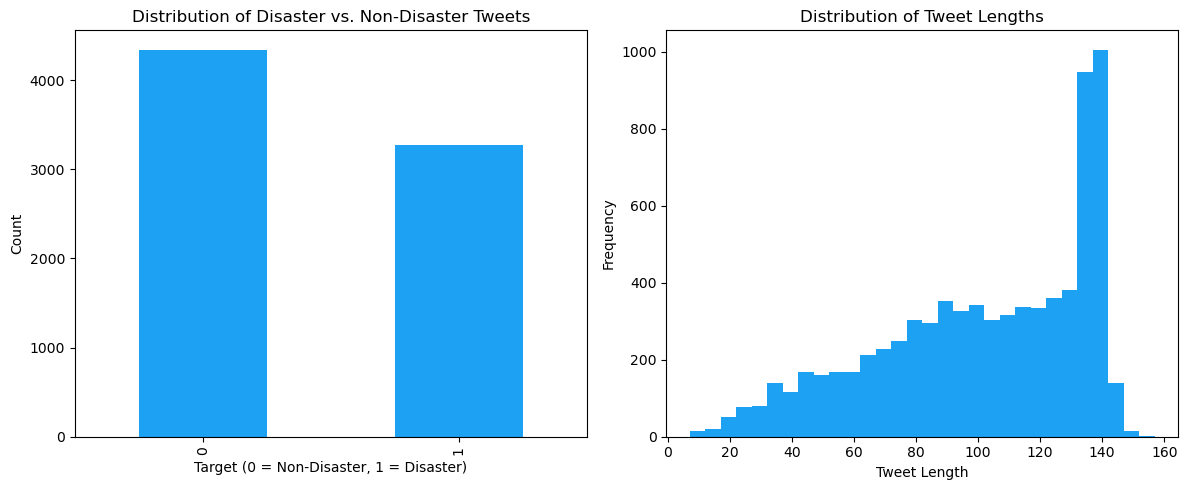

In [526]:
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(12, 5))

# Plot the distribution of the target variable
plt.subplot(1, 2, 1)
train_df['target'].value_counts().plot(kind='bar', color = '#1DA1F2')
plt.title('Distribution of Disaster vs. Non-Disaster Tweets')
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Count')

# Plot the distribution of tweet lengths
plt.subplot(1, 2, 2)
train_df['tweet_length'] = train_df['text'].apply(len)
train_df['tweet_length'].plot(kind='hist', bins=30, color = '#1DA1F2')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

## Determine if there is class imbalance

In [528]:
# Calculate the proportion of each class in the target variable
class_proportions = train_df['target'].value_counts(normalize=True) * 100
class_counts = train_df['target'].value_counts()

class_proportions, class_counts

(target
 0    57.034021
 1    42.965979
 Name: proportion, dtype: float64,
 target
 0    4342
 1    3271
 Name: count, dtype: int64)

### Conclusion of EDA
1. No class imbalance

## Text Cleanup

In [531]:
import re
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define a function to clean the text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to the 'text' column
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

# Display the first few cleaned texts
train_df[['text', 'cleaned_text']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaizenx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",13 000 people receive wildfires evacuation ord...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


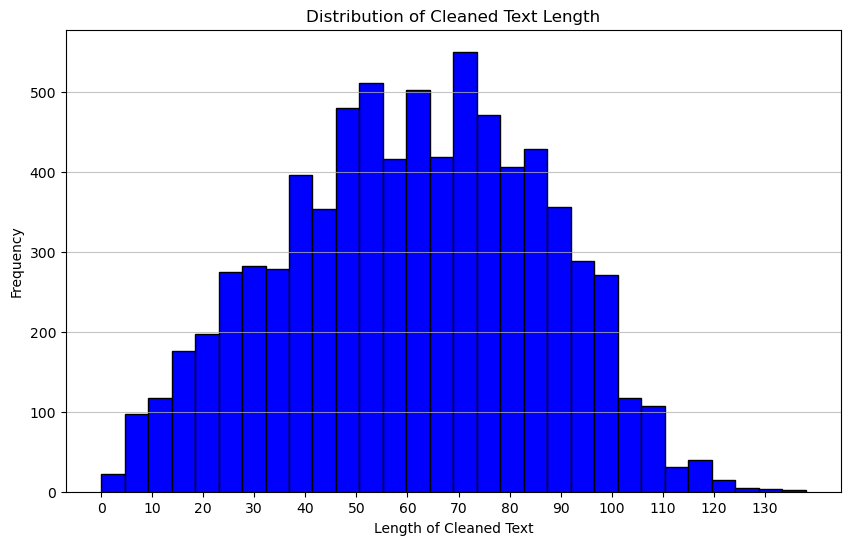

In [604]:
# Calculate the length of cleaned_text
train_df['cleaned_text_length'] = train_df['cleaned_text'].str.len()

# Plot the distribution of cleaned_text length
plt.figure(figsize=(10, 6))
plt.hist(train_df['cleaned_text_length'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Cleaned Text Length')
plt.xlabel('Length of Cleaned Text')
plt.ylabel('Frequency')
plt.xticks(range(0, train_df['cleaned_text_length'].max() + 1, 10))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [606]:
max_length = train_df['cleaned_text'].str.len().max()
max_length

138

In [532]:
# Use cleaned_text in training
X = train_df["cleaned_text"]
y = train_df["target"]
X_test = test_df["text"]


In [533]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.1)

In [617]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import F1Score

In [650]:
# Step 1: Tokenize and Pad the Sequences
# Initialize the tokenizer and fit on the training data
tokenizer = Tokenizer(num_words = 3000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad the sequences to the maximum length found in the training data
max_length = 130  # Define a max length based on tweet length analysis or trial and error
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Step 2: Build and Compile the Model
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
# embedding from 50 to 300 because 300 is a common value
embedding_dim = 300                        # Dimension of embedding vector
# lstm went from 64
lstm_units = 64                        # Number of LSTM units

# Define the model
model = Sequential()
# Add embedding layer
model.add(Embedding(input_dim=3000, output_dim=embedding_dim))
model.add(SpatialDropout1D(0.2))  # Decrease from 0.3 to 0.2
model.add(LSTM(units=lstm_units, dropout=0.2, return_sequences=True))  # Set return_sequences=True for stacking LSTMs
model.add(LSTM(units=lstm_units, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


# Set the initial learning rate
initial_learning_rate = 0.1

# Configure the optimizer with the initial learning rate
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model with the configured optimizer
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold = 0.5)])

In [651]:
# Define the path to save the model
model_save_path = 'model/disaster_tweet_model.keras'

# Step 3: Train the Model
# Include ModelCheckpoint to save the best model during training
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitors validation loss
    factor=0.1,            # Reduces the learning rate by a factor of 10
    patience=2,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6            # Sets a minimum learning rate limit
)

# Batch size went from 32 to 16
history = model.fit(X_train_pad, y_train, 
                    epochs=20, 
                    batch_size=16, 
                    validation_data=(X_val_pad, y_val), 
                    verbose=1,
                    callbacks=[checkpoint, reduce_lr])

# Model summary (optional)
model.summary()

Epoch 1/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - f1_score: 0.4068 - loss: 0.7516
Epoch 1: val_loss improved from inf to 0.68726, saving model to model/disaster_tweet_model.keras
429/429 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - f1_score: 0.4067 - loss: 0.7516 - val_f1_score: 0.0000e+00 - val_loss: 0.6873 - learning_rate: 0.1000
Epoch 2/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - f1_score: 0.3179 - loss: 0.7117
Epoch 2: val_loss did not improve from 0.68726
429/429 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - f1_score: 0.3179 - loss: 0.7117 - val_f1_score: 0.6120 - val_loss: 0.7198 - learning_rate: 0.1000
Epoch 3/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - f1_score: 0.3395 - loss: 0.7213
Epoch 3: val_loss did not improve from 0.68726
429/429 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - f1_score: 0.3395 - loss: 0.7213 - val_f1_score: 0.0000e+00 - val_loss: 0.9150 - learning_rate: 0.1000
Epoch 4/20
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - f1_score: 0.2129 - loss: 0.7061
Epoch 4: val_loss did no

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 130, 300)       │       900,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_17            │ (None, 130, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 130, 64)        │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,079,589 (11.75 MB)

 Trainable params: 1,026,529 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,053,060 (7.83 MB)

## Model performance 

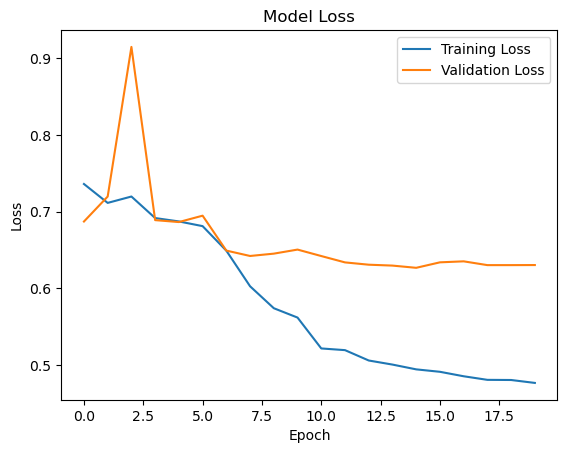

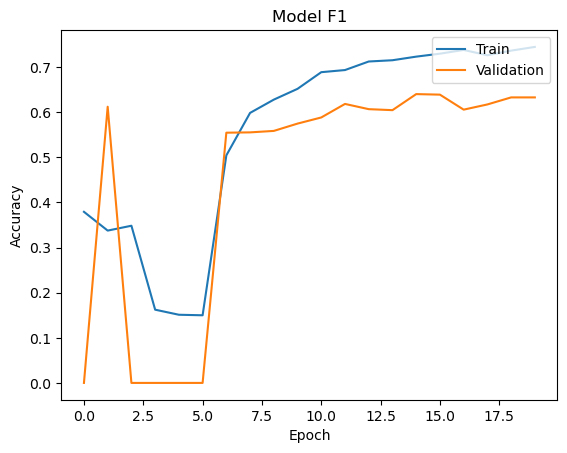

In [653]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



## Prediction

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


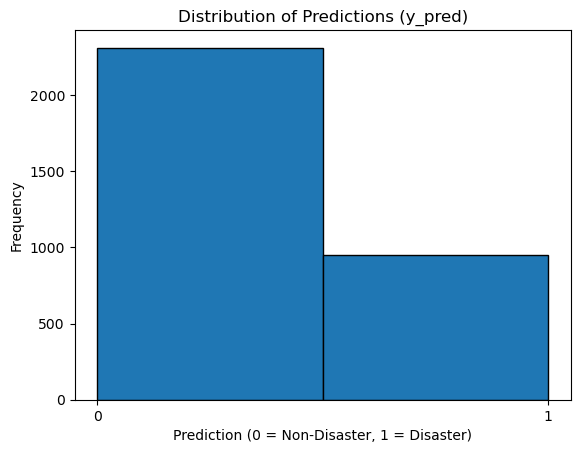

In [655]:

# Load the model
model = load_model('model/disaster_tweet_model.keras')

# Step 1: Tokenize and Pad the Test Data
# Assuming tokenizer was fitted on the training data
X_test_seq = tokenizer.texts_to_sequences(test_df["text"])
X_test_pad = pad_sequences(X_test_seq, padding='post')


# Step 2: Make Predictions
# Get the probability predictions for each test example
predictions = model.predict(X_test_pad)
if predictions.shape[1] > 1:  # If more than one output per sample
    y_pred = (predictions[:, 1] > 0.5).astype(int)  # Choose one column (e.g., for binary classification)
else:
    y_pred = (predictions > 0.5).astype(int).flatten()

y_pred[:10]  # Display the first 10 predictions for reference


# Plot histogram of y_pred
plt.hist(y_pred, bins=2, edgecolor='black')
plt.xticks([0, 1])
plt.xlabel('Prediction (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions (y_pred)')
plt.show()





In [656]:
print(len(df_predictions))

3263


In [657]:
# Create the DataFrame with 'id' from the first column of X_test
df_predictions = pd.DataFrame({'id': test_df["id"], 'target': y_pred})

# Save the DataFrame to a CSV file
df_predictions.to_csv('submissions.csv', index=False) 